In [6]:
import numpy as np
from master_lib.utils import files_and_directories
import pandas as pd
from master_lib.model.generator import DataGenerator
from master_lib.loader.data_loader import dataset_partition
from master_lib.model.callbacks import BCP
from typing import List

# model definition
import PIL
import os
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

num_classes = 4

sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

model_archive = r'C:\Users\MikołajStryja\Documents\Studia\master\trained_models'
model_name = 'Sequential_7_pyramid_cnn'

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce GTX 1650 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2078258399854242960
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2254123828
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1392989966993411364
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [7]:
# Callbacks
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=7, verbose=1)

filepath = r'C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints'

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(filepath, model_name), monitor='val_loss', verbose=1, save_best_only=False,
    save_weights_only=False, mode='auto', save_freq='epoch',
    options=None
)

def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

learning_rate = tf.keras.callbacks.LearningRateScheduler(
    scheduler, verbose=1
)

bcp_callback = BCP()

In [8]:
dataset_path = r'C:\Users\MikołajStryja\Documents\Studia\master\dataset.json'
dataset = files_and_directories.load_json(dataset_path)
dataset_images = r'C:\Users\MikołajStryja\Documents\Studia\siim-covid19-detection'
dataset = files_and_directories.load_json(dataset_path)
train_imgs = files_and_directories.list_train_images(dataset_images)
Xtrain, Xval, Xeval = dataset_partition(train_imgs)
training_generator = DataGenerator(Xtrain, batch_size=32, equalization=0)
validation_generator = DataGenerator(Xval, batch_size=32, equalization=0)
evaluation_generator = DataGenerator(Xeval, batch_size=32, shuffle=False)

dataset length: 6054
Evaluation Cases: 150
Train cases: 4133
Validation cases: 1771


In [9]:
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(512, 512, 1)),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu', name="first_conv2d_filter"),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (5, 5), padding='same', activation='relu', name="second_conv2d_filter"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (5, 5), padding='same', activation='relu', name="third_conv2d_filter"),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (5, 5), padding='same', activation='relu', name="fourth_conv2d_filter"),
    layers.MaxPooling2D(),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu', name="fith_conv2d_filter"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

In [10]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 512, 512, 1)       0         
_________________________________________________________________
first_conv2d_filter (Conv2D) (None, 512, 512, 16)      160       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 256, 256, 16)      0         
_________________________________________________________________
second_conv2d_filter (Conv2D (None, 256, 256, 32)      12832     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
third_conv2d_filter (Conv2D) (None, 128, 128, 64)      51264     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 64, 64, 64)       

In [11]:
model.fit(training_generator,
        epochs=20,
        validation_data=validation_generator,
        verbose=1,
        callbacks=[early_stop, learning_rate, checkpoint, bcp_callback])

Epoch 1/20

Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
121/129 [===========================>..] - ETA: 1:02 - loss: 1.2774 - accuracy: 0.4664

C:\ProgramData\Anaconda3\lib\site-packages\pydicom\pixel_data_handlers\numpy_handler.py:359: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


129/129 [==============================] - 1458s 11s/step - loss: 1.2766 - accuracy: 0.4666 - val_loss: 1.2274 - val_accuracy: 0.4710

Epoch 00001: saving model to C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\Sequential_7_pyramid_cnn
INFO:tensorflow:Assets written to: C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\Sequential_7_pyramid_cnn\assets
Epoch 2/20

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000474974513.
 93/129 [====================>.........] - ETA: 4:26 - loss: 1.2243 - accuracy: 0.4731

C:\ProgramData\Anaconda3\lib\site-packages\pydicom\pixel_data_handlers\numpy_handler.py:359: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


129/129 [==============================] - 1411s 11s/step - loss: 1.2166 - accuracy: 0.4714 - val_loss: 1.2264 - val_accuracy: 0.4705

Epoch 00002: saving model to C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\Sequential_7_pyramid_cnn
INFO:tensorflow:Assets written to: C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\Sequential_7_pyramid_cnn\assets
Epoch 3/20

Epoch 00003: LearningRateScheduler setting learning rate to 0.0010000000474974513.
 23/129 [====>.........................] - ETA: 13:23 - loss: 1.2198 - accuracy: 0.4633

C:\ProgramData\Anaconda3\lib\site-packages\pydicom\pixel_data_handlers\numpy_handler.py:359: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


129/129 [==============================] - 1434s 11s/step - loss: 1.2112 - accuracy: 0.4724 - val_loss: 1.1964 - val_accuracy: 0.5023

Epoch 00003: saving model to C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\Sequential_7_pyramid_cnn
INFO:tensorflow:Assets written to: C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\Sequential_7_pyramid_cnn\assets
Epoch 4/20

Epoch 00004: LearningRateScheduler setting learning rate to 0.0010000000474974513.
101/129 [======================>.......] - ETA: 3:39 - loss: 1.1955 - accuracy: 0.5006

C:\ProgramData\Anaconda3\lib\site-packages\pydicom\pixel_data_handlers\numpy_handler.py:359: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


129/129 [==============================] - 1432s 11s/step - loss: 1.1913 - accuracy: 0.5024 - val_loss: 1.1805 - val_accuracy: 0.5398

Epoch 00004: saving model to C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\Sequential_7_pyramid_cnn
INFO:tensorflow:Assets written to: C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\Sequential_7_pyramid_cnn\assets
Epoch 5/20

Epoch 00005: LearningRateScheduler setting learning rate to 0.0010000000474974513.
117/129 [==========================>...] - ETA: 1:32 - loss: 1.1619 - accuracy: 0.5355

C:\ProgramData\Anaconda3\lib\site-packages\pydicom\pixel_data_handlers\numpy_handler.py:359: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


129/129 [==============================] - 1433s 11s/step - loss: 1.1593 - accuracy: 0.5368 - val_loss: 1.1457 - val_accuracy: 0.5472

Epoch 00005: saving model to C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\Sequential_7_pyramid_cnn
INFO:tensorflow:Assets written to: C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\Sequential_7_pyramid_cnn\assets
Epoch 6/20

Epoch 00006: LearningRateScheduler setting learning rate to tf.Tensor(0.0009048374, shape=(), dtype=float32).
 95/129 [=====================>........] - ETA: 4:22 - loss: 1.1241 - accuracy: 0.5618

C:\ProgramData\Anaconda3\lib\site-packages\pydicom\pixel_data_handlers\numpy_handler.py:359: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


129/129 [==============================] - 1461s 11s/step - loss: 1.1301 - accuracy: 0.5579 - val_loss: 1.1322 - val_accuracy: 0.5483

Epoch 00006: saving model to C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\Sequential_7_pyramid_cnn
INFO:tensorflow:Assets written to: C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\Sequential_7_pyramid_cnn\assets
Epoch 7/20

Epoch 00007: LearningRateScheduler setting learning rate to tf.Tensor(0.0008187307, shape=(), dtype=float32).
 32/129 [======>.......................] - ETA: 12:20 - loss: 1.1263 - accuracy: 0.5566

C:\ProgramData\Anaconda3\lib\site-packages\pydicom\pixel_data_handlers\numpy_handler.py:359: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


129/129 [==============================] - 1483s 11s/step - loss: 1.1033 - accuracy: 0.5700 - val_loss: 1.1145 - val_accuracy: 0.5608

Epoch 00007: saving model to C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\Sequential_7_pyramid_cnn
INFO:tensorflow:Assets written to: C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\Sequential_7_pyramid_cnn\assets
Epoch 8/20

Epoch 00008: LearningRateScheduler setting learning rate to tf.Tensor(0.0007408181, shape=(), dtype=float32).
113/129 [=========================>....] - ETA: 2:08 - loss: 1.0757 - accuracy: 0.5824

C:\ProgramData\Anaconda3\lib\site-packages\pydicom\pixel_data_handlers\numpy_handler.py:359: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


129/129 [==============================] - 1498s 12s/step - loss: 1.0831 - accuracy: 0.5775 - val_loss: 1.1030 - val_accuracy: 0.5676

Epoch 00008: saving model to C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\Sequential_7_pyramid_cnn
INFO:tensorflow:Assets written to: C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\Sequential_7_pyramid_cnn\assets
Epoch 9/20

Epoch 00009: LearningRateScheduler setting learning rate to tf.Tensor(0.0006703199, shape=(), dtype=float32).
 36/129 [=======>......................] - ETA: 12:39 - loss: 1.0482 - accuracy: 0.5972

C:\ProgramData\Anaconda3\lib\site-packages\pydicom\pixel_data_handlers\numpy_handler.py:359: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


129/129 [==============================] - 1497s 12s/step - loss: 1.0668 - accuracy: 0.5843 - val_loss: 1.1093 - val_accuracy: 0.5625

Epoch 00009: saving model to C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\Sequential_7_pyramid_cnn
INFO:tensorflow:Assets written to: C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\Sequential_7_pyramid_cnn\assets
Epoch 10/20

Epoch 00010: LearningRateScheduler setting learning rate to tf.Tensor(0.00060653046, shape=(), dtype=float32).
 92/129 [====================>.........] - ETA: 4:54 - loss: 1.0343 - accuracy: 0.5941

C:\ProgramData\Anaconda3\lib\site-packages\pydicom\pixel_data_handlers\numpy_handler.py:359: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


129/129 [==============================] - 1445s 11s/step - loss: 1.0383 - accuracy: 0.5930 - val_loss: 1.1067 - val_accuracy: 0.5722

Epoch 00010: saving model to C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\Sequential_7_pyramid_cnn
INFO:tensorflow:Assets written to: C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\Sequential_7_pyramid_cnn\assets
Epoch 11/20

Epoch 00011: LearningRateScheduler setting learning rate to tf.Tensor(0.00054881145, shape=(), dtype=float32).
 57/129 [============>.................] - ETA: 9:35 - loss: 1.0122 - accuracy: 0.6080

C:\ProgramData\Anaconda3\lib\site-packages\pydicom\pixel_data_handlers\numpy_handler.py:359: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


129/129 [==============================] - 1422s 11s/step - loss: 1.0160 - accuracy: 0.5996 - val_loss: 1.1182 - val_accuracy: 0.5625

Epoch 00011: saving model to C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\Sequential_7_pyramid_cnn
INFO:tensorflow:Assets written to: C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\Sequential_7_pyramid_cnn\assets
Epoch 12/20

Epoch 00012: LearningRateScheduler setting learning rate to tf.Tensor(0.0004965851, shape=(), dtype=float32).
 80/129 [=================>............] - ETA: 6:06 - loss: 0.9823 - accuracy: 0.6148

C:\ProgramData\Anaconda3\lib\site-packages\pydicom\pixel_data_handlers\numpy_handler.py:359: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


129/129 [==============================] - 1425s 11s/step - loss: 0.9933 - accuracy: 0.6090 - val_loss: 1.1418 - val_accuracy: 0.5608

Epoch 00012: saving model to C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\Sequential_7_pyramid_cnn
INFO:tensorflow:Assets written to: C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\Sequential_7_pyramid_cnn\assets
Epoch 13/20

Epoch 00013: LearningRateScheduler setting learning rate to tf.Tensor(0.00044932874, shape=(), dtype=float32).
108/129 [========================>.....] - ETA: 2:36 - loss: 0.9571 - accuracy: 0.6160

C:\ProgramData\Anaconda3\lib\site-packages\pydicom\pixel_data_handlers\numpy_handler.py:359: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


129/129 [==============================] - 1442s 11s/step - loss: 0.9583 - accuracy: 0.6182 - val_loss: 1.1439 - val_accuracy: 0.5545

Epoch 00013: saving model to C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\Sequential_7_pyramid_cnn
INFO:tensorflow:Assets written to: C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\Sequential_7_pyramid_cnn\assets
Epoch 14/20

Epoch 00014: LearningRateScheduler setting learning rate to tf.Tensor(0.00040656942, shape=(), dtype=float32).
 44/129 [=========>....................] - ETA: 10:45 - loss: 0.9071 - accuracy: 0.6385

C:\ProgramData\Anaconda3\lib\site-packages\pydicom\pixel_data_handlers\numpy_handler.py:359: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


129/129 [==============================] - 1454s 11s/step - loss: 0.9211 - accuracy: 0.6323 - val_loss: 1.1811 - val_accuracy: 0.5597

Epoch 00014: saving model to C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\Sequential_7_pyramid_cnn
INFO:tensorflow:Assets written to: C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\Sequential_7_pyramid_cnn\assets
Epoch 15/20

Epoch 00015: LearningRateScheduler setting learning rate to tf.Tensor(0.0003678792, shape=(), dtype=float32).
 50/129 [==========>...................] - ETA: 9:57 - loss: 0.8748 - accuracy: 0.6444 

C:\ProgramData\Anaconda3\lib\site-packages\pydicom\pixel_data_handlers\numpy_handler.py:359: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


129/129 [==============================] - 1424s 11s/step - loss: 0.8853 - accuracy: 0.6424 - val_loss: 1.2145 - val_accuracy: 0.5562

Epoch 00015: saving model to C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\Sequential_7_pyramid_cnn
INFO:tensorflow:Assets written to: C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\Sequential_7_pyramid_cnn\assets
Epoch 00015: early stopping


In [12]:
#len(BCP.batch_accuracy)/9
model.save(os.path.join(model_archive, model_name))

INFO:tensorflow:Assets written to: C:\Users\MikołajStryja\Documents\Studia\master\trained_models\Sequential_7_pyramid_cnn\assets


In [13]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
epochs = model.history.epoch
keys = model.history.history.keys()
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']

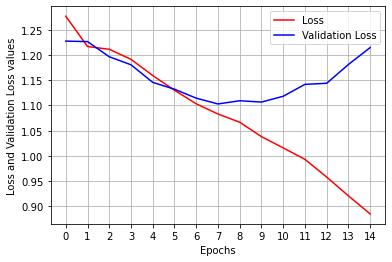

In [14]:
plt.plot(epochs, loss, 'r-', label='Loss')
plt.plot(epochs, val_loss, 'b-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss and Validation Loss values')
plt.grid()
plt.xticks(epochs)
plt.legend()

plt.savefig(os.path.join(r'C:\Users\MikołajStryja\Documents\Studia\do_magisterki_obrazy', model_name + '_loss.png'))

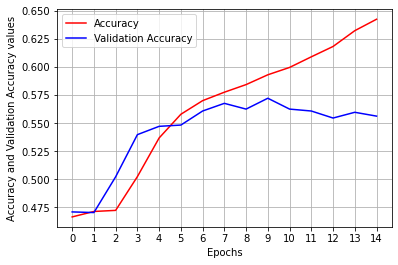

In [15]:
plt.plot(epochs, acc, 'r-', label='Accuracy')
plt.plot(epochs, val_acc, 'b-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy and Validation Accuracy values')
plt.grid()
plt.xticks(epochs)
plt.legend()

plt.savefig(os.path.join(r'C:\Users\MikołajStryja\Documents\Studia\do_magisterki_obrazy', model_name + '_acc.png'))

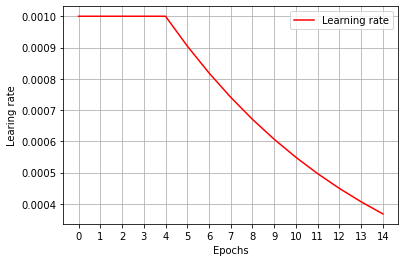

In [16]:
lr = model.history.history['lr']

plt.plot(epochs, lr, 'r-', label='Learning rate')
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Learing rate')
plt.xticks(epochs)
plt.legend()

plt.savefig(os.path.join(r'C:\Users\MikołajStryja\Documents\Studia\do_magisterki_obrazy', model_name + '_lr.png'))

In [17]:
len(BCP.batch_loss)/9

215.0

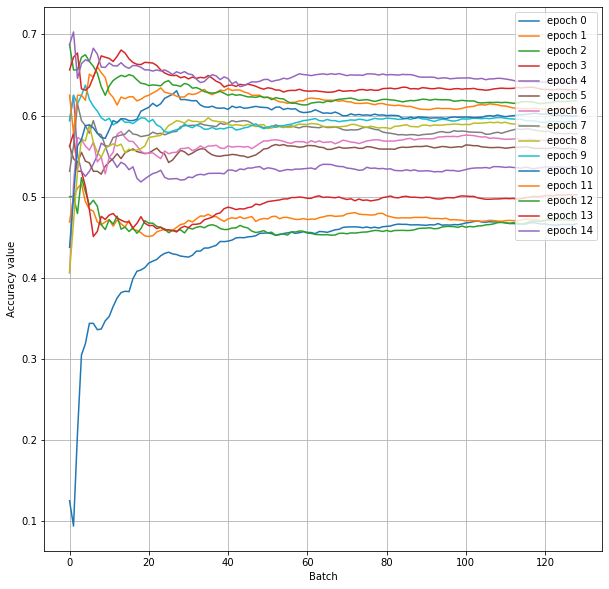

In [18]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
epochs = model.history.epoch
steps_per_epoch = int(len(BCP.batch_loss)/len(epochs))

for i in epochs:
    ax.plot(range(steps_per_epoch), BCP.batch_accuracy[i*steps_per_epoch:(i+1)*steps_per_epoch], label=f'epoch {i}')

ax.legend(loc='upper right')
ax.set_xlabel('Batch')
ax.set_ylabel('Accuracy value')
ax.grid()

plt.savefig(os.path.join(r'C:\Users\MikołajStryja\Documents\Studia\do_magisterki_obrazy', model_name + '_acc_per_epoch.png'))

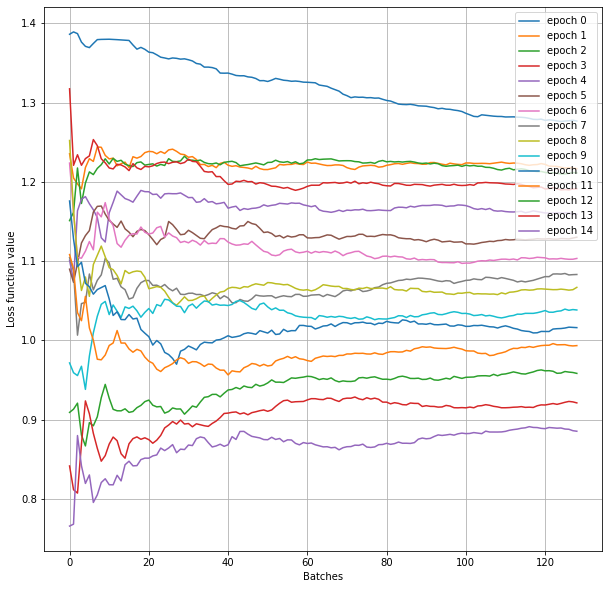

In [19]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
epochs = model.history.epoch
steps_per_epoch = int(len(BCP.batch_loss)/len(epochs))

for i in epochs:
    ax.plot(range(steps_per_epoch), BCP.batch_loss[i*steps_per_epoch:(i+1)*steps_per_epoch], label=f'epoch {i}')

ax.legend(loc='upper right')
ax.set_xlabel('Batches')
ax.set_ylabel('Loss function value')
ax.grid()

plt.savefig(os.path.join(r'C:\Users\MikołajStryja\Documents\Studia\do_magisterki_obrazy', model_name + '_loss_per_epoch.png'))

In [27]:
results = model.predict(evaluation_generator)
"""
for elem in results:
    max_value = np.where(elem == np.amax(elem))
    elem[max_value] = 1
    elem[elem != 1] = 0
"""

'\nfor elem in results:\n    max_value = np.where(elem == np.amax(elem))\n    elem[max_value] = 1\n    elem[elem != 1] = 0\n'

In [21]:
from master_lib.loader.data_loader import evaluate_categories
gt = []
for elem in Xeval[:len(results)]:
    gt.append(evaluate_categories(os.path.basename(elem)))

In [28]:
for x, y in zip(results, gt):
    print(f"Predicted: {x}, True label: {y}")

Predicted: [4.2489002e-04 2.8761229e-01 1.8789352e-01 5.2406931e-01], True label: [0 1 0 0]
Predicted: [4.2988520e-04 2.8984299e-01 1.8771903e-01 5.2200806e-01], True label: [0 1 0 0]
Predicted: [4.2952038e-04 2.8796405e-01 1.8838832e-01 5.2321810e-01], True label: [0 0 1 0]
Predicted: [4.3014984e-04 2.8854775e-01 1.8866181e-01 5.2236027e-01], True label: [0 0 0 1]
Predicted: [4.3049199e-04 2.8940028e-01 1.8936945e-01 5.2079976e-01], True label: [0 0 0 1]
Predicted: [4.3664104e-04 2.8861558e-01 1.9111578e-01 5.1983202e-01], True label: [0 0 0 1]
Predicted: [4.4015519e-04 2.8765082e-01 1.9229345e-01 5.1961553e-01], True label: [0 0 1 0]
Predicted: [4.3872648e-04 2.8893456e-01 1.9191383e-01 5.1871288e-01], True label: [0 0 0 1]
Predicted: [4.2285156e-04 2.8912610e-01 1.8422952e-01 5.2622151e-01], True label: [0 0 1 0]
Predicted: [4.3834071e-04 2.9057559e-01 1.9063783e-01 5.1834822e-01], True label: [0 0 0 1]
Predicted: [4.3561787e-04 2.8784892e-01 1.9133841e-01 5.2037710e-01], True label

In [25]:
m = tf.keras.metrics.Precision()
r = tf.keras.metrics.Recall()
m.update_state(results, gt)
r.update_state(results, gt)
precision = m.result().numpy()
recall = r.result().numpy()
precision, recall, 2*precision*recall/(precision + recall)

(0.453125, 0.453125, 0.453125)

In [23]:
min(loss), min(val_loss)

(0.8853189945220947, 1.1030004024505615)

In [24]:
max(acc), max(val_acc)

(0.6424418687820435, 0.5721591114997864)